In [1]:
import keras
from keras.layers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import multiprocessing as mp

df = pd.read_pickle('df_S300_featurized')
df = df.replace([np.inf, -np.inf, np.nan], 0)
df_X = df.drop('Input Data|S_300_atom',axis=1)
a = {}
for x in df_X.columns:
    if 'ChemEnvSiteFingerprint|GaussianSymmFunc' in x:
        a[x] = 'GaussianSymmFunc|'+x[39:]
df_X = df_X.rename(a,axis=1)

df_Y = df[['Input Data|S_300_atom']]

df_X=(df_X-df_X.min())/(df_X.max()-df_X.min())
#df_Y=(df_Y-df_Y.min())/(df_Y.max()-df_Y.min())
df_X = df_X.replace([np.inf, -np.inf, np.nan], 0)

cross_mi = pd.read_pickle('Features_cross_OLD')
S300_mi = pd.read_pickle('Features_S300')
a = []
for x in cross_mi.index:
    if x not in S300_mi.index:
        a.append(x)
        
cross_mi = cross_mi.drop(a,axis=0).drop(a,axis=1)

def get_features(n,p=2,c=0.2):

    score = cross_mi.copy()
    for i in score.index:
        row = score.loc[i,:]
        score.loc[i,:] = S300_mi[i] /(row**p+c)

    first_feature = S300_mi.nlargest(1).index[0]
    score = score.drop(first_feature,axis=0)
    feature_set = [first_feature]

    for _ in range(n-1):
        next_feature = score[feature_set].min(axis=1).idxmax(axis=0)
        feature_set.append(next_feature)
        score = score.drop(next_feature,axis=0)
    #print(feature_set)
    return feature_set

def merge_df(df1,df2):
    for x in df2.columns:
        for y in df2.index:
            df1.loc[x,y] =+ df2.loc[xy]
    return df1
  
def CV_NN(model,df_X,df_Y,cv=5,epochs=200,batch_size=100,plot = False):
  df_X,df_Y = shuffle(df_X,df_Y)
  size = df_X.shape[0]
  mae_score = np.zeros(cv)
  map_score = np.zeros(cv)
  
  weights = model.get_weights()
  
  for i in range(cv):
    fit_params = {
            'x': df_X.values,
            'y': df_Y.values,
            'epochs': epochs+20,
            'batch_size': batch_size,
            'verbose': 0,
            'validation_split' : 1/cv
    }
    
    model.set_weights(weights)
    history = model.fit(**fit_params)
    mae =  history.history['mean_absolute_error']
    val_map = history.history['mean_absolute_percentage_error']
    val_mae = history.history['val_mean_absolute_error']   
    score = np.sort(val_mae)[:40].mean()
    score_p = np.sort(val_map)[:40].mean()
    mae_score[i] = score
    map_score[i] = score_p
    temp = df_X.iloc[:size//cv,:]
    idx = temp.index
    df_X = df_X.drop(idx,axis=0)
    df_X = df_X.append(temp)
    temp = df_Y.loc[idx,:]
    df_Y = df_Y.drop(idx,axis=0)
    df_Y = df_Y.append(temp)
    if plot:
      fig, ax = plt.subplots(figsize=(6,6))
      ax.plot(mae,label='mae')
      ax.plot(val_mae,label='val_mae')
      # ax.set_ylim([0,6])
      ax.set_title('entropy @ 300K')
      ax.set_ylabel('MAE [J/Kmol]')
      ax.set_ylabel('epochs')
      ax.legend()
      #fig.savefig("e{}.jpg".format(str(T)))
      ax.grid()
      
  return (mae_score.mean(), map_score.mean())

def gen_model(n_features):
    f_input = Input(shape=(n_features,))
    hidden1 = Dense(int(n_features/2)+2,activation='relu')(f_input)
    #hidden2 = Dense(int(n_features/2)+2,activation='relu')(hidden1)
    out = Dense(1,activation='linear')(hidden1) #output is bounded below
    model = keras.models.Model(f_input,out)
    model.compile(loss = 'mae', metrics=['mae','mean_absolute_percentage_error'],
                  optimizer=keras.optimizers.Adam(0.01))
    return model
  
def grid_search_single(df_X,df_Y,p_values,c_values,n_features,queue):
  
  df_mae = pd.DataFrame([],index=p_values,columns=c_values)
  df_map = pd.DataFrame([],index=p_values,columns=c_values)
  iterations = len(p_values)*len(c_values)*len(features)
  i = 1
  for p in p_values:
    for c in c_values:
      mae_score = []
      map_score = []
      for n in n_features:
        print('{}/{}'.format(i,iterations))
        features = get_features(n=n,p=p,c=c)
        X = df_X[features]
        Y = df_Y
        #print("n_features: {} - p={} - c={}".format(n,p,c))
        model = gen_model(n)
        best_score, best_scorep = CV_NN(model,X,Y)
        mae_score += [best_score]
        map_score += [best_scorep]
        i+=1
      df_mae.loc[p,c] = mae_score
      df_map.loc[p,c] = map_score
      
    queue.put((df_mae,df_map))
    
output = mp.Queue()

def grid_search_multi(df_X,df_Y,p_values,c_values,n_features):
    proc = 5
    delta = len(n_features)//proc
    ns = [n_features[i*delta:(i+1)*delta] for i in range(proc)]
    print(ns)
    if __name__ == "__main__":
        processes = [mp.Process(target=grid_search_single, args=(df_X,df_Y,p_values,c_values,n,output)) for n in ns]

        for p in processes:
            p.start()

        for p in processes:
            p.join()

        results = [output.get() for p in processes]
        df_mae = merge_df(results[0][0],results[1][0])
        df_map = merge_df(results[0][1],results[1][1])

        for r in results[2:]:
            df_mae = merge_df(df_mae,r[0])
            df_map = merge_df(df_map,r[1])

        return (df_mae,df_map)
    
def grid_search(df_X,df_Y,p_values,c_values,n_features):
  
  df_mae = pd.DataFrame([],index=p_values,columns=c_values)
  df_map = pd.DataFrame([],index=p_values,columns=c_values)
  iterations = len(p_values)*len(c_values)*len(n_features)
  i = 1
  for p in p_values:
    for c in c_values:
      mae_score = []
      map_score = []
      for n in n_features:
        print('{}/{}'.format(i,iterations))
        features = get_features(n=n,p=p,c=c)
        X = df_X[features]
        Y = df_Y
        #print("n_features: {} - p={} - c={}".format(n,p,c))
        model = gen_model(n)
        best_score, best_scorep = CV_NN(model,X,Y)
        mae_score += [best_score]
        map_score += [best_scorep]
        i+=1
      df_mae.loc[p,c] = mae_score
      df_map.loc[p,c] = map_score
      
  return (df_mae,df_map)

Using TensorFlow backend.


In [ ]:
p_values = [0.5, 1, 2]
p_values = [1]
c_values = [0.01, 0.1, 1]
c_values = [0.1]
n_features = [4,5,6,7,8,9,10,15,20,25,30,35,40,50,60,70,80,90,100,
              120,140,160,180,200,250,300,350,400,500,600,700,800,900,1000]
df_mae,df_map = grid_search(df_X,df_Y,p_values = p_values,c_values = c_values,n_features=n_features)

1/34
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [1]:
import pandas as pd
print(pd.__version__)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')

large = 22; med = 20; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

0.24.1


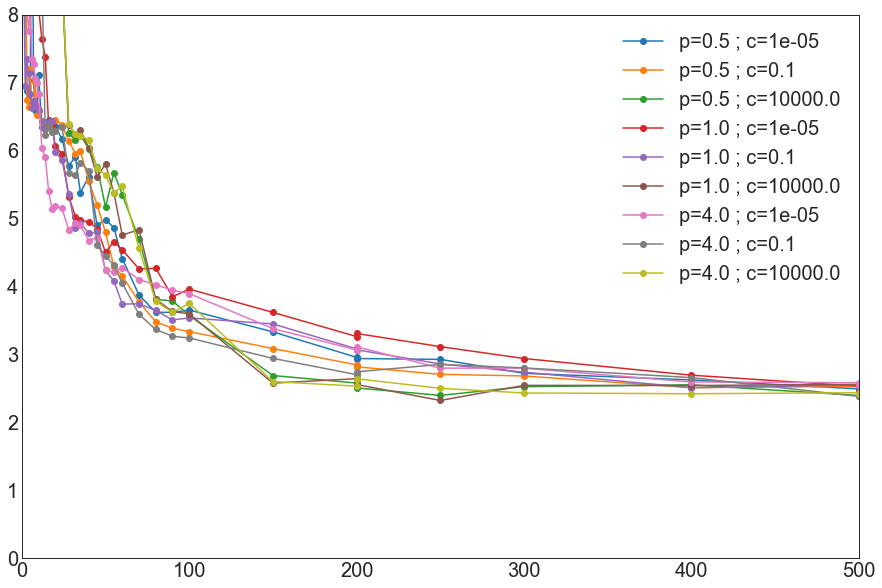

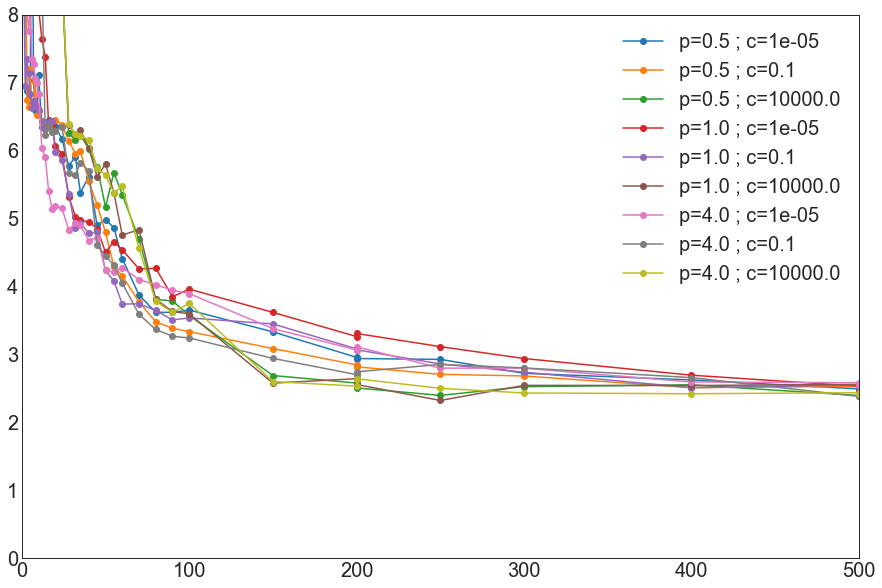

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

map_l = [2.561572391534426]
mae_l = [3.060641782915736]

# 2 layer, 2 neuron bias
df_mae = pd.read_pickle('df2_mae_final')
n = [[1,2,3,4,5,6,7,8,9,10],[12,14,16,18,20],[24,28,32],[35,40,45],
      [50,55,60],[70,80,90],[100,150,200],[200,250,300],
      [400,500],[500,600],[700,800],[900],[1100]]
n = [x for a in n for x in a]
fig, ax = plt.subplots(figsize=(15,10))
for p in df_mae.index:
    for c in df_mae.columns:
        ax.plot(n,df_mae.loc[p,c],'-o',label='p={} ; c={}'.format(p,c))
ax.set_xlim([0,500])
ax.set_ylim([0,8])
ax.legend()

# 1 layer, 2 neuron bias
df_map = pd.read_pickle('df_mae_final')
n = [[1,2,3,4,5,6,7,8,9,10],[12,14,16,18,20],[24,28,32],[35,40,45],
      [50,55,60],[70,80,90],[100,150,200],[200,250,300],
      [400,500],[500,600],[700,800],[900],[1100]]
n = [x for a in n for x in a]
fig, ax = plt.subplots(figsize=(15,10))
for p in df_map.index:
    for c in df_map.columns:
        ax.plot(n,df_map.loc[p,c],'-o',label='p={} ; c={}'.format(p,c))
ax.set_xlim([0,500])
ax.set_ylim([0,8])
ax.legend()
ax.legend()

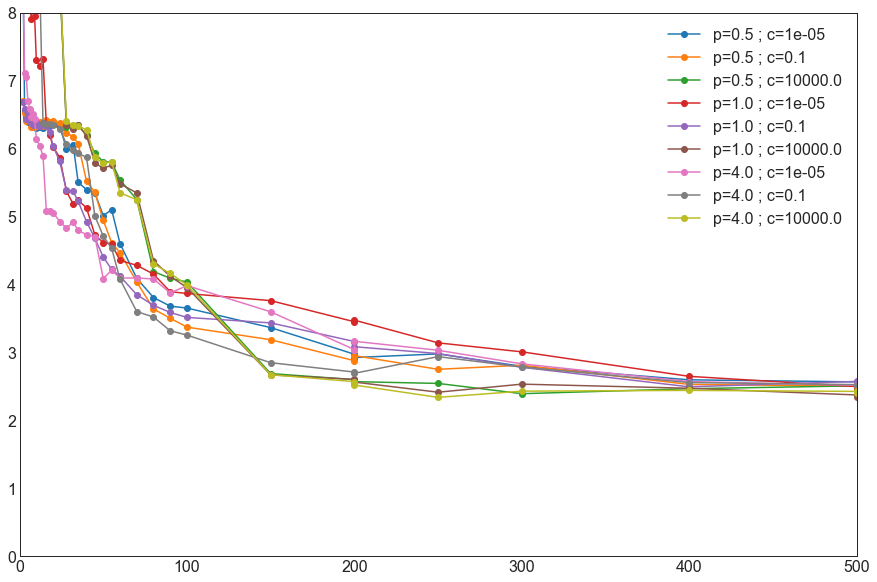

In [18]:
# 1 layer, 100 neuron bias
df_map = pd.read_pickle('df1_100_mae_final')
n = [[2,3,4,5,6,7,8,9,10],[12,14,16,18,20],[24,28,32],[35,40,45],
      [50,55,60],[70,80,90],[100,150,200],[200,250,300],
      [400,500],[500,600],[700,800],[900],[1100],[2038]]
n = [x for a in n for x in a]
fig, ax = plt.subplots(figsize=(15,10))
for p in df_map.index:
    for c in df_map.columns:
        ax.plot(n,df_map.loc[p,c]+map_l,'-o',label='p={} ; c={}'.format(p,c))
#ax.set_xlim([0,700])
ax.set_ylim([0,8])
ax.set_xlim([0,500])
ax.set_ylim([0,8])
ax.legend()

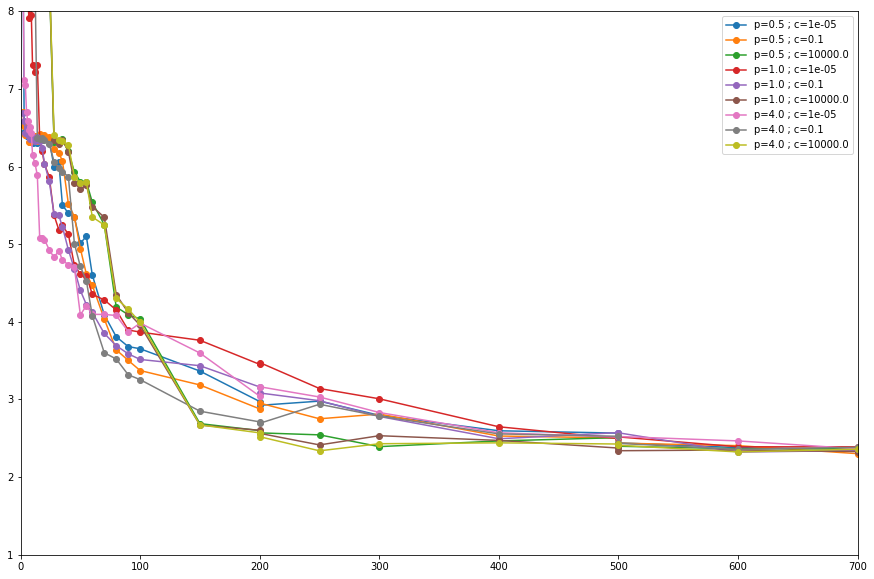

In [9]:
# 1 layer, 100 neuron bias
df_map = pd.read_pickle('df1_100_mae_final')
n = [[2,3,4,5,6,7,8,9,10],[12,14,16,18,20],[24,28,32],[35,40,45],
      [50,55,60],[70,80,90],[100,150,200],[200,250,300],
      [400,500],[500,600],[700,800],[900],[1100]]
n = [x for a in n for x in a]
fig, ax = plt.subplots(figsize=(15,10))
for p in df_map.index:
    for c in df_map.columns:
        ax.plot(n,df_map.loc[p,c],'-o',label='p={} ; c={}'.format(p,c))
ax.set_xlim([0,700])
ax.set_ylim([1,8])
ax.legend()

# GRID

(0, 10)

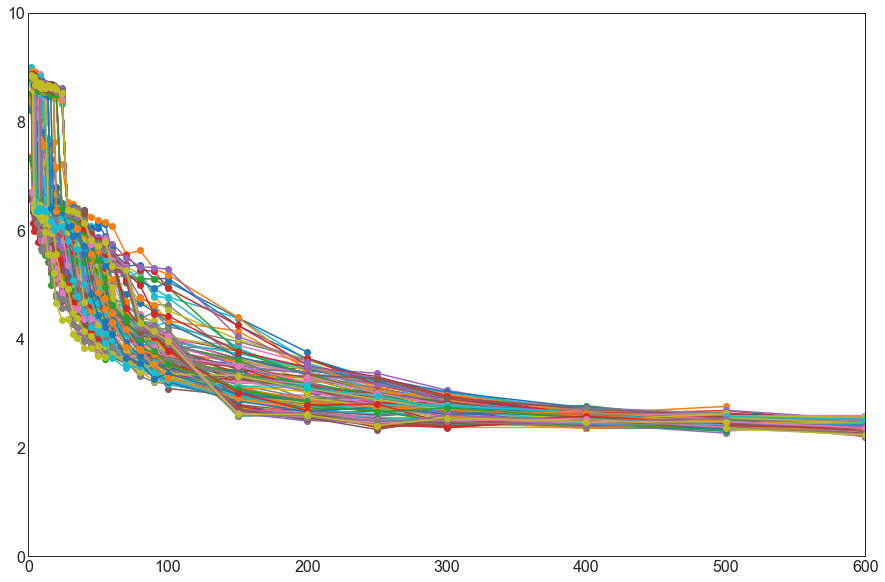

In [58]:
# 1 layer, 100 neuron bias
df_map = pd.read_pickle('df1_100_mae_final_grid')
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 200, 250, 300, 400, 500, 500, 600, 700, 800, 900, 1100]
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 200, 250, 300, 400, 500, 500,600,700,800,2038]
fig, ax = plt.subplots(figsize=(15,10))
for p in df_map.index:
    for c in df_map.columns:
        ax.plot(n,df_map.loc[p,c]+map_l,'-o',label='p={} ; c={}'.format(p,c))
ax.set_xlim([0,600])
ax.set_ylim([0,10])
#ax.legend()

(0, 10)

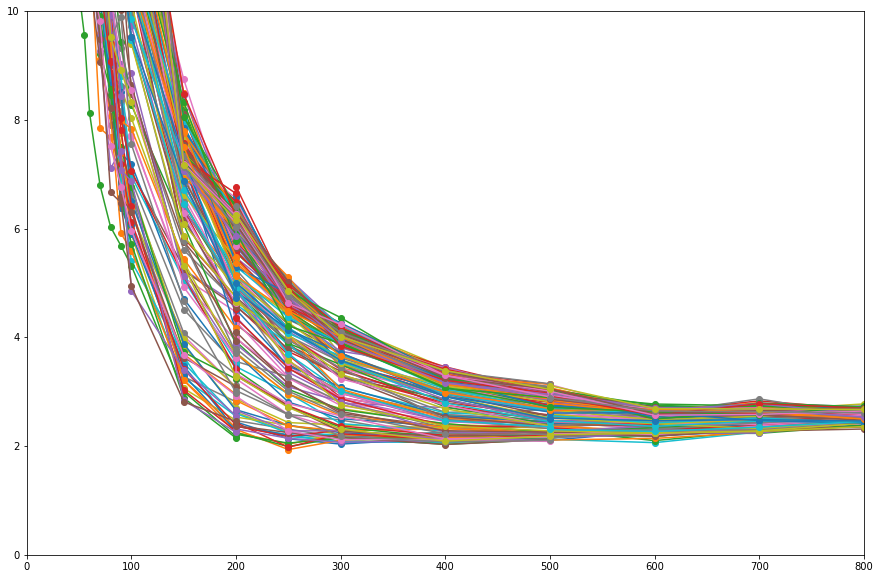

In [15]:
# 1 layer, 100 neuron bias
df_map = pd.read_pickle('df1_100_map_final_grid')
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 200, 250, 300, 400, 500, 500, 600, 700, 800, 900, 1100]
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 200, 250, 300, 400, 500, 500,600,700,800,2038]
fig, ax = plt.subplots(figsize=(15,10))
for p in df_map.index:
    for c in df_map.columns:
        ax.plot(n,df_map.loc[p,c]+map_l,'-o',label='p={} ; c={}'.format(p,c))
ax.set_xlim([0,800])
ax.set_ylim([0,10])
#ax.legend()

(0, 10)

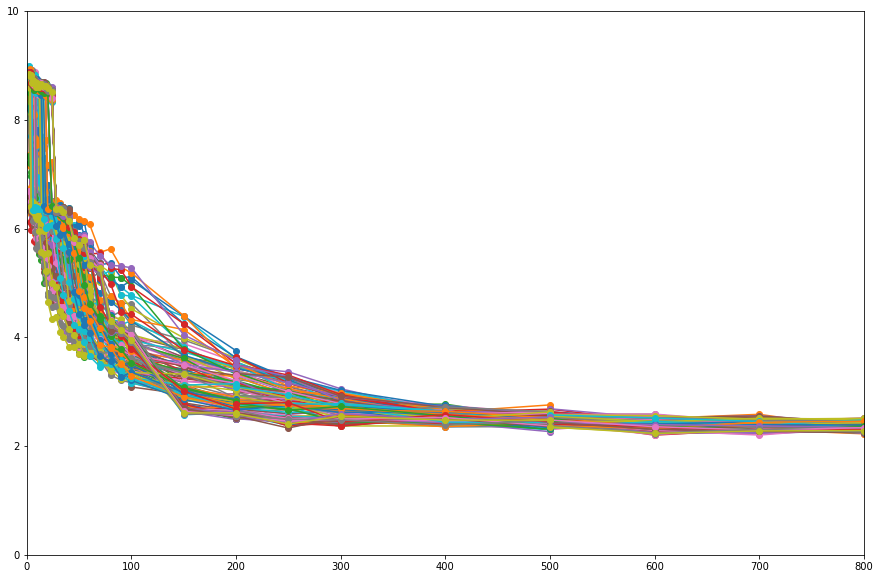

In [16]:
# 1 layer, 100 neuron bias
df_map = pd.read_pickle('df1_100_mae_final_grid')
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 200, 250, 300, 400, 500, 500, 600, 700, 800, 900, 1100]
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 200, 250, 300, 400, 500, 500,600,700,800,2038]
fig, ax = plt.subplots(figsize=(15,10))
for p in df_map.index:
    for c in df_map.columns:
        ax.plot(n,df_map.loc[p,c]+map_l,'-o',label='p={} ; c={}'.format(p,c))
ax.set_xlim([0,800])
ax.set_ylim([0,10])
#ax.legend()

# 16 validation (error corrected)

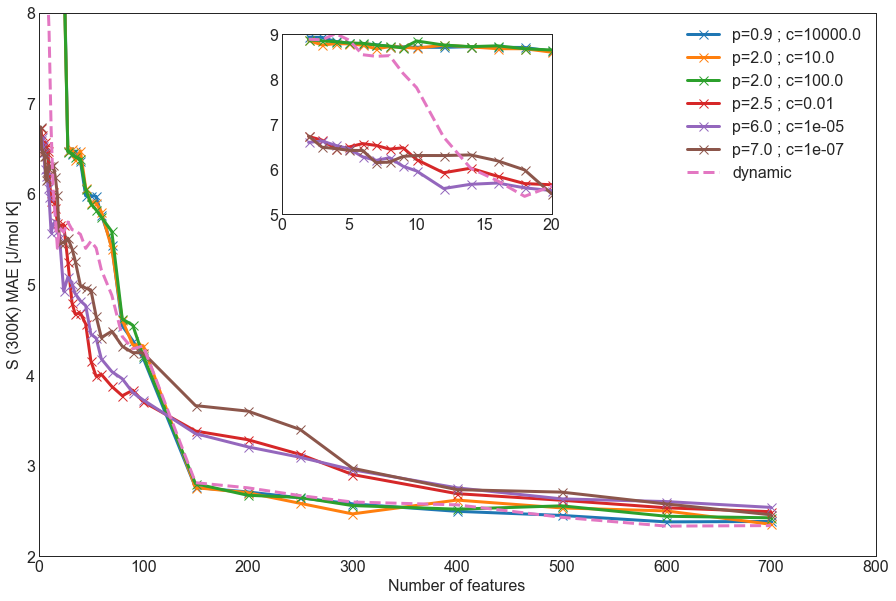

In [49]:
# 1 layer, 100 neuron bias
df_map = pd.read_pickle('df1_16_mae_X')
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1100]
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 250, 300, 400, 500,600,700]
fig, ax = plt.subplots(figsize=(15,10))

left, bottom, width, height = [0.35, 0.6, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

for p in df_map.index:
    for c in df_map.columns:
        if (p,c) in [(6,1e-5),(7,1e-7),(2.5,0.01),(2,10),(2,100),(0.9,10000)]:
            y = df_map.loc[p,c]
            y[28] = (y[28] + y[29])/2
            del y[29]
            y[-4] = (y[-4] + y[-3])/2
            del y[-3]
            ax.plot(n,y,'-x',label='p={} ; c={}'.format(p,c),markersize=9,linewidth = 3)
            ax2.plot(n,y,'-x',label='p={} ; c={}'.format(p,c),markersize=9,linewidth = 3)
#ax.plot(n,np.load('dyn_feat_0.npy'),'-o',label='dynamic0'.format(p,c))
y = list(np.load('dyn_feat_4.npy'))
y[-4] = (y[-4] + y[-3])/2
del y[-3]
ax.plot(n,y,'--',label='dynamic'.format(p,c),linewidth=3)
ax2.plot(n,y,'--',label='dynamic'.format(p,c),linewidth=3)
#ax.plot(n,np.load('dyn_feat_2.npy'),'-o',label='dynamic2'.format(p,c))
ax.set_xlim([0,800])
ax.set_ylim([2,8])
ax2.set_xlim([0,20])
ax2.set_ylim([5,9])
ax.legend()
ax.set_xlabel('Number of features')
ax.set_ylabel('S (300K) MAE [J/mol K]')
fig.savefig('pc-curve.pdf')

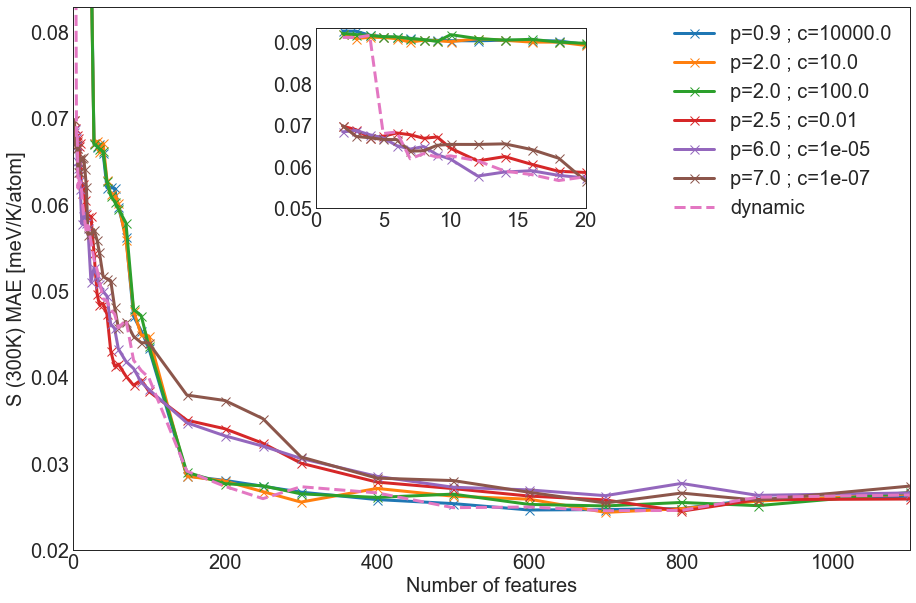

In [14]:
# 1 layer, 100 neuron bias
cst = (1.60218e-22 * 6.02214e23)
df_map = pd.read_pickle('df1_16_mae_X')
df_mae_B = pd.read_pickle('df1_16_mae_B')
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1100]

n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1100]

fig, ax = plt.subplots(figsize=(15,10))

left, bottom, width, height = [0.35, 0.6, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

for p in df_map.index:
    for c in df_map.columns:
        if (p,c) in [(6,1e-5),(7,1e-7),(2.5,0.01),(2,10),(2,100),(0.9,10000)]:
            y = df_map.loc[p,c]
            yB = df_mae_B.loc[p,c]
            y[28] = (y[28] + y[29])/2
            del y[29]
            y[-4] = (y[-4] + y[-3])/2
            del y[-3]
            ax.plot(n,np.array(y+yB)/cst,'-x',label='p={} ; c={}'.format(p,c),markersize=9,linewidth = 3)
            ax2.plot(n,np.array(y+yB)/cst,'-x',label='p={} ; c={}'.format(p,c),markersize=9,linewidth = 3)
#ax.plot(n,np.load('dyn_feat_0.npy'),'-o',label='dynamic0'.format(p,c))
y = list(np.load('dyn_feat_1.npy'))
y[-7] = (y[-7] + y[-7])/2
del y[-6]
ax.plot(n,np.array(y)/cst,'--',label='dynamic'.format(p,c),linewidth=3)
ax2.plot(n,np.array(y)/cst,'--',label='dynamic'.format(p,c),linewidth=3)
#ax.plot(n,np.load('dyn_feat_2.npy'),'-o',label='dynamic2'.format(p,c))
ax.set_xlim([0,1100])
ax.set_ylim([2/cst,8/cst])
ax2.set_xlim([0,20])
ax2.set_ylim([5/cst,9/cst])
ax.legend()
ax.set_xlabel('Number of features')
ax.set_ylabel('S (300K) MAE [meV/K/atom]')
ax2.set_yticks([0.05,0.06,0.07,0.08,0.09])
ax.set_yticks([0.02,0.03,0.04,0.05,0.06,0.07,0.08])
fig.savefig('pc-curve3.pdf')

In [2]:
df_mae_B = pd.read_pickle('df1_16_mae_B')
df_mae_B

1.000000e-07  \
0.1   [2.3865434867598445, 2.532801258085243, 2.4946...   
0.3   [2.4150617690928966, 2.49131745915815, 2.60704...   
0.5   [2.4247967016170304, 2.4433969939640727, 2.580...   
0.7   [2.3646554004571523, 2.4785956005686254, 2.615...   
0.9   [2.381119449033316, 2.5439744848946497, 2.6900...   
1.1   [2.456198068828468, 2.5750845562214835, 2.5256...   
1.5   [2.4371293403202268, 2.4012901143711733, 2.462...   
2.0   [2.4148543891585974, 2.4880308811348604, 2.585...   
2.5   [2.3486819806515453, 2.4757855531848576, 2.499...   
3.0   [2.4870853439033267, 2.4963048007928705, 2.615...   
3.5   [2.433541342752526, 2.454792138323726, 2.53432...   
4.0   [2.3592219675353254, 2.574529458332253, 2.5729...   
4.5   [2.4838871925518697, 2.409000216688976, 2.4646...   
5.0   [2.500359528617687, 2.4476759825581054, 2.5758...   
6.0   [2.534234718697138, 2.5060936795971003, 2.5922...   
7.0   [2.5688368243050865, 2.4886465273899248, 2.646...   
8.0   [2.567968234489242, 2.4268251951607356, 2.6587...   
9.0   [2.5834270981037952, 2.4243008665243786, 2.502...   
10.0  [2.5144127824794813, 2.432661781854419, 2.6333...   

                                           1.000000e-05  \
0.1   [2.3690063782700572, 2.4170537577336093, 2.517...   
0.3   [2.527285582459117, 2.444533372696145, 2.49734...   
0.5   [2.4140627312253278, 2.5110145020245547, 2.439...   
0.7   [2.4959719949362276, 2.431853815096928, 2.5713...   
0.9   [2.4435605815854897, 2.4154434569102214, 2.660...   
1.1   [2.4475864461195993, 2.4576237297225667, 2.530...   
1.5   [2.4106779412428536, 2.4380569380426023, 2.479...   
2.0   [2.414612117503063, 2.484567589714345, 2.55010...   
2.5   [2.5143917739798267, 2.491701145828009, 2.6076...   
3.0   [2.460736201125455, 2.510803873572484, 2.59863...   
3.5   [2.40586007498115, 2.4392077637269316, 2.60669...   
4.0   [2.5010756115022916, 2.4333373749112512, 2.557...   
4.5   [2.4999314087988385, 2.4763802898744025, 2.591...   
5.0   [2.559220505038418, 2.5044761799305797, 2.6251...   
6.0   [2.6765561655462986, 2.5434834742522145, 2.570...   
7.0   [2.483576104959331, 2.5133013698877575, 2.4468...   
8.0   [2.4927640137830416, 2.53065979446752, 2.54213...   
9.0   [2.5802511044630565, 2.462580071781055, 2.5180...   
10.0  [2.625447244866785, 2.52143442747344, 2.709355...   

                                           1.000000e-03  \
0.1   [2.4560977299242133, 2.503861464111202, 2.4963...   
0.3   [2.4177086685268754, 2.491249871694419, 2.5937...   
0.5   [2.387489462425431, 2.464290694074937, 2.58743...   
0.7   [2.4076500799880924, 2.564163828657334, 2.6732...   
0.9   [2.413622387247871, 2.4756762956112746, 2.5374...   
1.1   [2.377134642213224, 2.4343326686328677, 2.5610...   
1.5   [2.384589550696224, 2.5475211076228974, 2.6448...   
2.0   [2.4238516509963803, 2.582482557215365, 2.5310...   
2.5   [2.4318693407663856, 2.423416500728293, 2.4650...   
3.0   [2.4881463894451477, 2.4511405070479135, 2.563...   
3.5   [2.4155397636129194, 2.4968007736057642, 2.594...   
4.0   [2.5303274215416733, 2.38726967624153, 2.68771...   
4.5   [2.5615874679045505, 2.4573747277451328, 2.569...   
5.0   [2.5379487476099927, 2.5000843331804234, 2.543...   
6.0   [2.5061471596300366, 2.362071029529514, 2.6136...   
7.0   [2.5756874386565274, 2.409368836475185, 2.5777...   
8.0   [2.5784578976190717, 2.523371972247779, 2.5242...   
9.0   [2.5082743990708547, 2.555055989740364, 2.6681...   
10.0  [2.587536964023927, 2.4614350366736035, 2.5336...   

                                           1.000000e-02  \
0.1   [2.445335508757327, 2.5562327316870173, 2.6030...   
0.3   [2.4938599468665905, 2.436065587916049, 2.5010...   
0.5   [2.374215033468473, 2.507394401395177, 2.52680...   
0.7   [2.3680579464741975, 2.3806660256831043, 2.543...   
0.9   [2.461411092374698, 2.482664342053444, 2.55400...   
1.1   [2.3972469581537936, 2.5329656434154892, 2.564...   
1.5   [2.40312720143412, 2.495581682180784, 2.595323...   
2.0   [2.398712048226571, 2.

C:\Users\Pierre-Paul\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


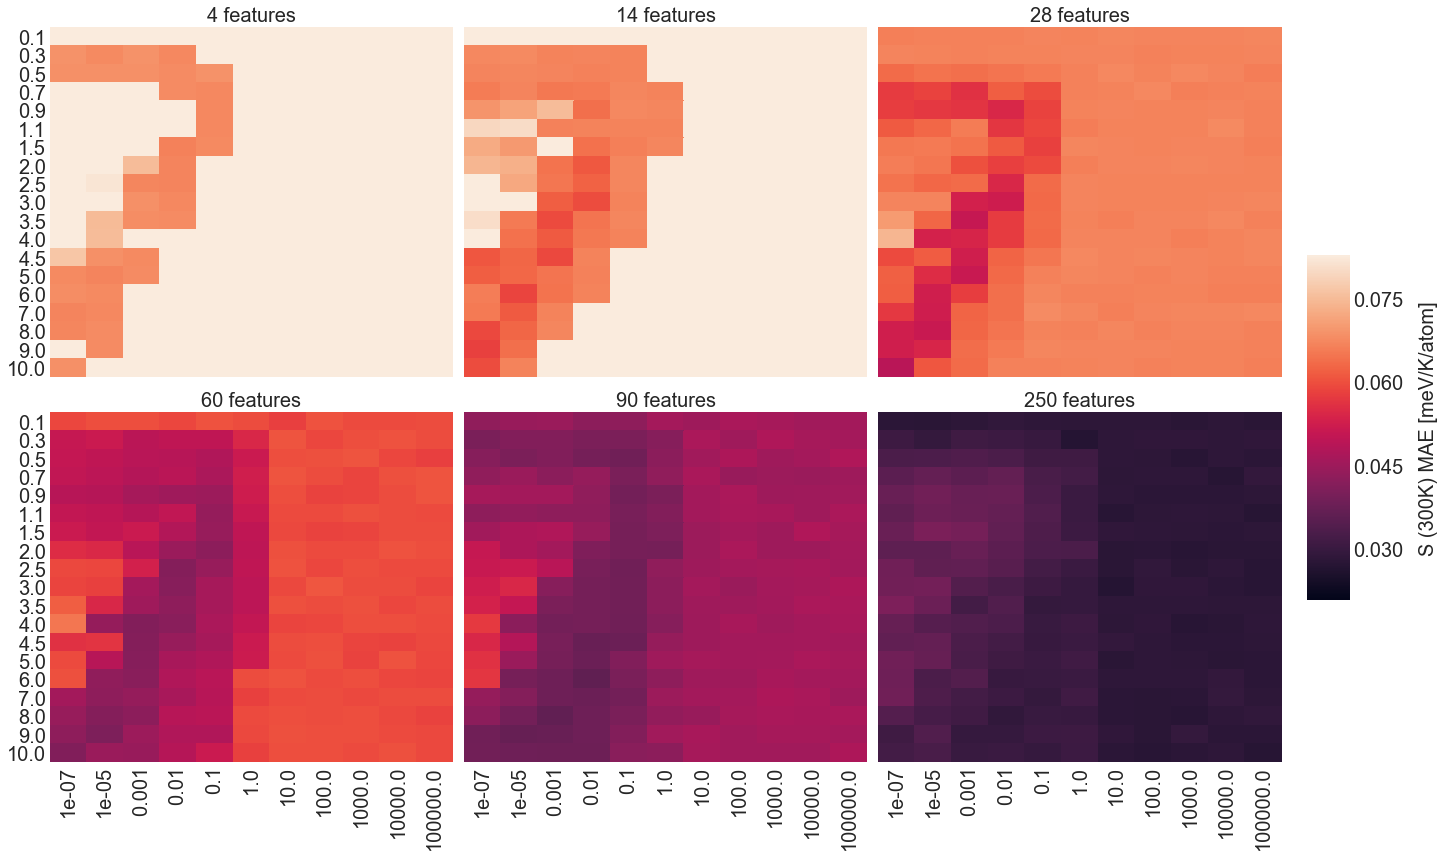

In [15]:
df_map = pd.read_pickle('df1_16_mae_X')

fig, axs = plt.subplots(2,3,figsize=(20,12),sharey=True,sharex=True)

fs = [2,10,15,22,25,29]
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i,ax in enumerate(axs.flat):
    df = df_map.applymap(lambda x : x[fs[i]])
    sns.heatmap(df/cst, xticklabels=df.columns, yticklabels=df.index, annot=False,ax=ax,cbar=i == 0,cbar_ax=None if i else cbar_ax,vmin=2/cst,vmax=8/cst)
    ax.set_title("{} features".format(n[fs[i]]), fontsize=20)
    #ax.tick_params(size=50)
    

cbar_ax.set_ylabel('S (300K) MAE [meV/K/atom]',labelpad=15)
fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig('pc_heatmaps2.pdf')

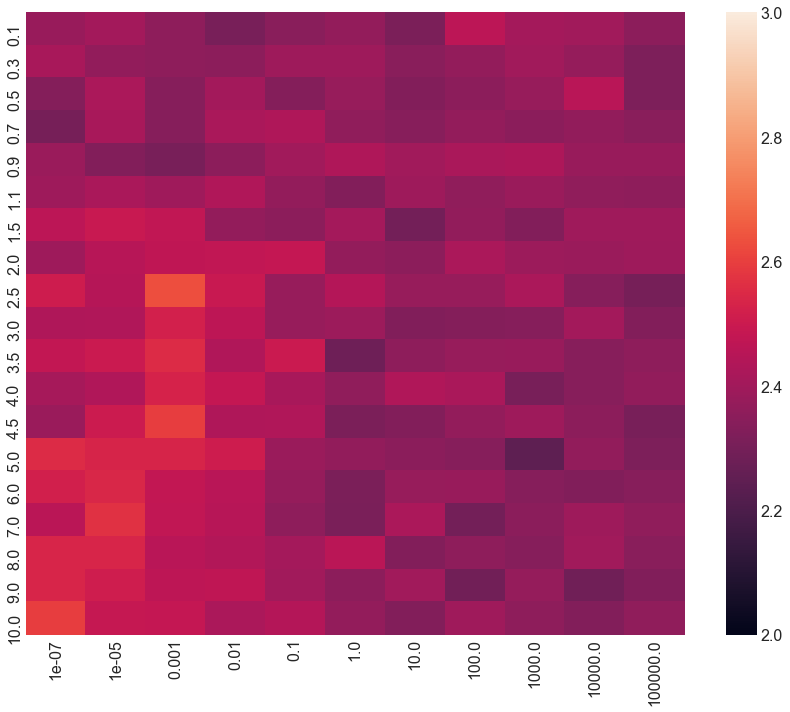

In [34]:
fig,ax = plt.subplots(figsize=(12,10))
df_map = pd.read_pickle('df1_16_mae_X')
df = df_map.applymap(lambda x : min(x))
sns.heatmap(df, xticklabels=df.columns, yticklabels=df.index, annot=False,ax=ax,vmin=2,vmax=3)
#ax.set_title("Difference in mutual information between {0} and {1} samples".format(400,4000), fontsize=42)
#ax.tick_params(size=50)
cbar = ax.collections[0].colorbar
fig.tight_layout()

In [60]:
import plotly.plotly as py
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly
pyo.init_notebook_mode()
#plotly.tools.set_credentials_file(username='ppdebreuck', api_key='NPgJdrMsDp53WigIKKNB')

trace = go.Heatmap(z=df.values,
                   x=df.columns,
                   y=df.index)
data=[trace]
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=go.layout.Margin(
        l=300,
        r=50,
        b=350,
        t=100,
        pad=4
    ),
    yaxis=dict(autorange='reversed'),
    xaxis=dict(tickangle=45),
    title=go.layout.Title(
        text='Normalized mutual information for compositional features (32,000 features)')
)

fig = go.Figure(data=data, layout=layout)
pyo.plot(fig, filename='pc_opt.html')

'file:///Users/ppdebreuck/School/Master_Thesis/Feature_selection/pc_opt.html'

150


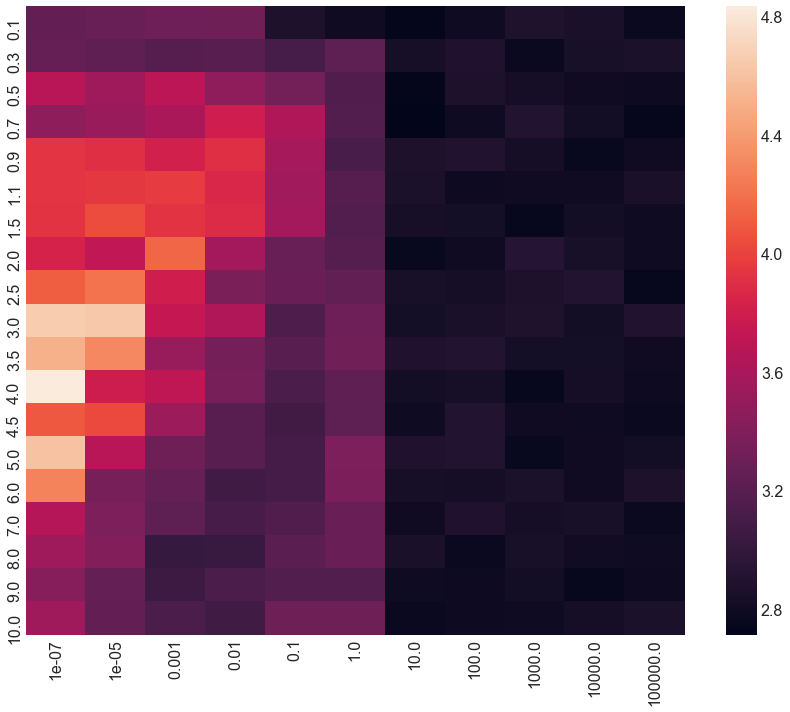

In [78]:
fig,ax = plt.subplots(figsize=(12,10))
df_map = pd.read_pickle('df1_16_mae_X')
df = df_map.applymap(lambda x : x[27])
print(n[27])
sns.heatmap(df, xticklabels=df.columns, yticklabels=df.index, annot=False,ax=ax)
#ax.set_title("Difference in mutual information between {0} and {1} samples".format(400,4000), fontsize=42)
#ax.tick_params(size=50)
cbar = ax.collections[0].colorbar
fig.tight_layout()

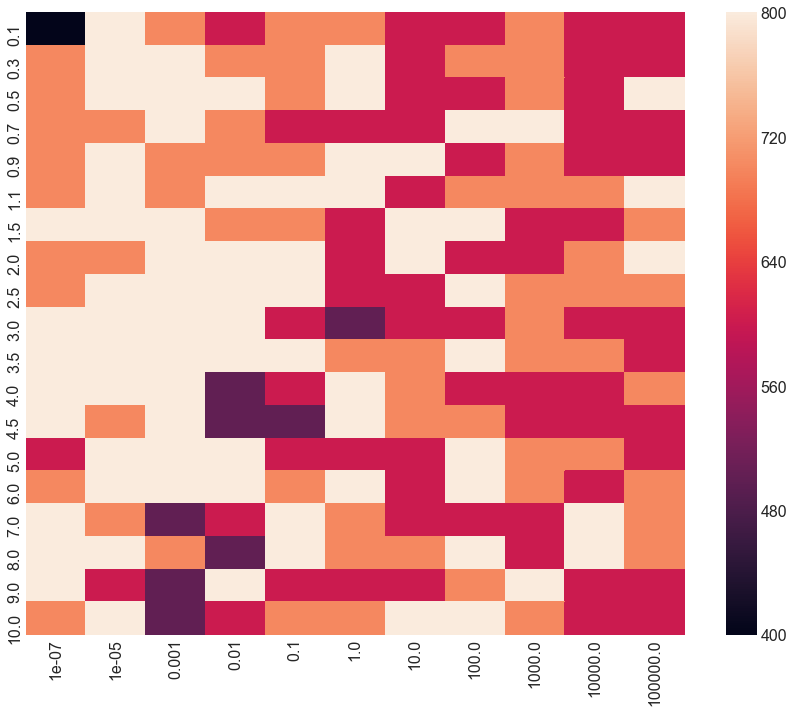

In [22]:
fig,ax = plt.subplots(figsize=(12,10))
df_map = pd.read_pickle('df1_100_mae_final_grid')
df = df_map.applymap(lambda x : n[np.array(x).argmin()])
sns.heatmap(df, xticklabels=df.columns, yticklabels=df.index, annot=False,ax=ax)
#ax.set_title("Difference in mutual information between {0} and {1} samples".format(400,4000), fontsize=42)
#ax.tick_params(size=50)
cbar = ax.collections[0].colorbar
fig.tight_layout()

In [42]:
np.array([1,2,3]).argmin()

0

In [149]:
from sklearn.feature_selection import mutual_info_regression as MI

a = np.array(list(range(600)))
a = np.array(a).reshape((600,1))
b = a + np.random.rand(600,1)*30

In [150]:
MI(a,b)

/anaconda3/envs/matenv/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/anaconda3/envs/matenv/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the scale function.



array([1.28491173])

In [165]:
MI((a-200)*100,b,n_neighbors=3)

/anaconda3/envs/matenv/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/anaconda3/envs/matenv/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning:

Data with input dtype int64 was converted to float64 by the scale function.



array([0.96147539])

In [2]:
import pandas as pd
pd.read_pickle('Features_S800')

ElementProperty|MagpieData minimum Number                                0.099606
ElementProperty|MagpieData maximum Number                                0.049534
ElementProperty|MagpieData range Number                                  0.030289
ElementProperty|MagpieData mean Number                                   0.081037
ElementProperty|MagpieData avg_dev Number                                0.010655
ElementProperty|MagpieData mode Number                                   0.102771
ElementProperty|MagpieData minimum MendeleevNumber                       0.041805
ElementProperty|MagpieData maximum MendeleevNumber                       0.074274
ElementProperty|MagpieData range MendeleevNumber                         0.036972
ElementProperty|MagpieData mean MendeleevNumber                          0.053739
ElementProperty|MagpieData avg_dev MendeleevNumber                       0.030439
ElementProperty|MagpieData mode MendeleevNumber                          0.081130
ElementProperty|

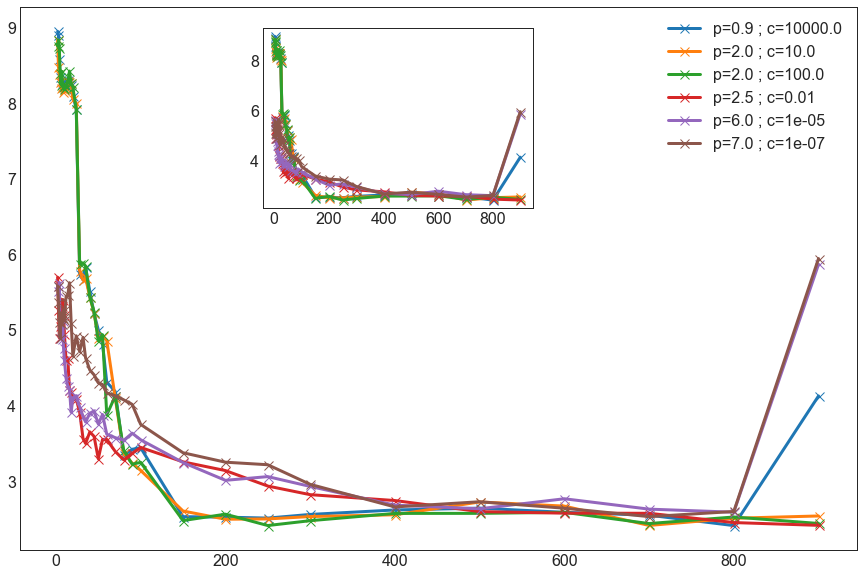

In [11]:
# 2 layer, 400 neuron bias
df_map = pd.read_pickle('df2_400_mae_X')
n = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 24, 28, 32, 35, 40, 45, 50, 55, 60,
      70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900]
fig, ax = plt.subplots(figsize=(15,10))

left, bottom, width, height = [0.35, 0.6, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
for p in df_map.index:
    for c in df_map.columns:
        if (p,c) in [(6,1e-5),(7,1e-7),(2.5,0.01),(2,10),(2,100),(0.9,10000)]:
            y = df_map.loc[p,c]
            y[28] = (y[28] + y[29])/2
            del y[29]
            y[-4] = (y[-4] + y[-3])/2
            del y[-3]
            ax.plot(n,y,'-x',label='p={} ; c={}'.format(p,c),markersize=9,linewidth = 3)
            ax2.plot(n,y,'-x',label='p={} ; c={}'.format(p,c),markersize=9,linewidth = 3)
ax.legend()